In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytz
import yfinance as yf
import seaborn as sns
import matplotlib.dates as mdates
import warnings
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, root_mean_squared_error
from datetime import datetime
warnings.filterwarnings("ignore")

Import BBNI Data

In [16]:
TICKER = "BBNI.JK"

start_date = "2021-01-01"

# use datetime.utcnow to get current UTC time
utc_now = datetime.utcnow()
local_tz = pytz.timezone("Asia/Jakarta")
local_now = pytz.utc.localize(utc_now).astimezone(local_tz)

end_date = local_now.strftime("%Y-%m-%d")

print(f"Current date (Jakarta): {end_date}")
print(f"Current time (Jakarta): {local_now.strftime('%Y-%m-%d %H:%M:%S')}")

df = yf.download(TICKER, start=start_date, end=end_date)

print(f"\nData BBNI.JK ({len(df)} days):")
print(f"Last available data: {df.index[-1].strftime('%Y-%m-%d')}")
print("\nLast 5 days:")
print(df.tail())

# Check if data for the end_date is available
if df.index[-1].strftime('%Y-%m-%d') == end_date:
    print(f"\n✅ Data for {end_date} is available")
else:
    print(f"\n⚠️  Data for {end_date} is not available")
    print(f"Last available data: {df.index[-1].strftime('%Y-%m-%d')}")

[*********************100%***********************]  1 of 1 completed

Current date (Jakarta): 2025-11-07
Current time (Jakarta): 2025-11-07 09:10:05

Data BBNI.JK (1169 days):
Last available data: 2025-11-06

Last 5 days:
Price        Close    High     Low    Open    Volume
Ticker     BBNI.JK BBNI.JK BBNI.JK BBNI.JK   BBNI.JK
Date                                                
2025-10-31  4380.0  4450.0  4350.0  4400.0  69141700
2025-11-03  4430.0  4460.0  4380.0  4390.0  40455000
2025-11-04  4450.0  4510.0  4430.0  4430.0  73342900
2025-11-05  4460.0  4480.0  4380.0  4400.0  43447700
2025-11-06  4440.0  4480.0  4430.0  4450.0  31809500

⚠️  Data for 2025-11-07 is not available
Last available data: 2025-11-06


Close Price Visualitation

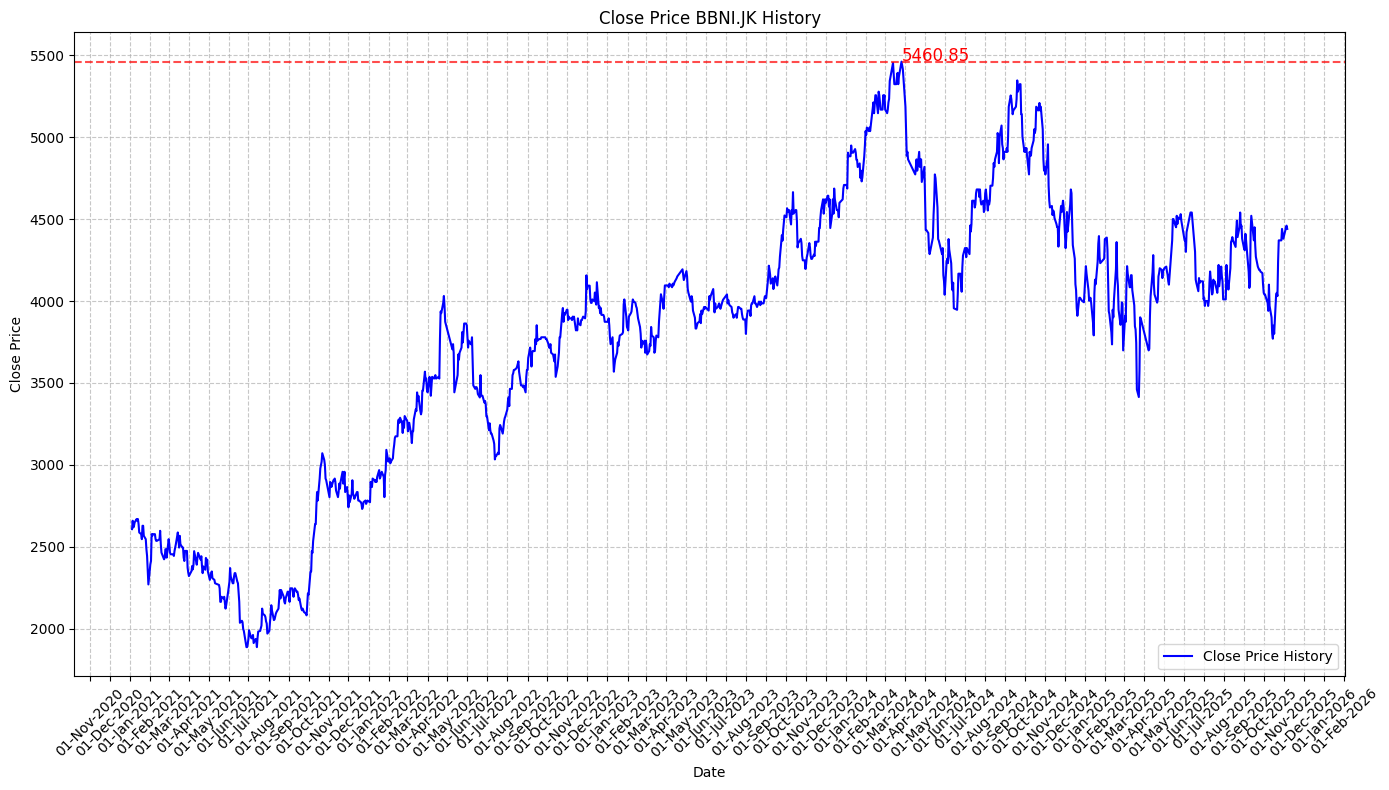

In [17]:
# Close price visualitation per month

try:
    close_series = df['Close'][TICKER]
except Exception:
    close_series = df['Close']

plt.figure(figsize=(14, 8))
sns.lineplot(x=close_series.index, y=close_series.values, label='Close Price History', color='blue')

max_price = float(close_series.max())
max_price_date = close_series.idxmax()

# Annotate the hight price
plt.annotate(f'{max_price:.2f}',
             xy=(max_price_date, max_price),
             xytext=(max_price_date, max_price + 2),
             fontsize=12, color='red')

plt.axhline(max_price, linestyle='--', color='red', alpha=0.7)
plt.title('Close Price BBNI.JK History')
plt.xlabel('Date')
plt.ylabel('Close Price')

# show tick only for weekdays
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))
plt.xticks(rotation=45)


plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

Preprocessing

In [18]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))
scaled_data

array([[0.20151362],
       [0.21582712],
       [0.20437635],
       ...,
       [0.71706643],
       [0.7198654 ],
       [0.71426746]])

Create function for train LSTM

In [19]:
def create_sequences(values, sequence_length: int):
    """values: array shape (N, 1) scaler result
    return:
    X: (num_samples, sequence_length, 1
    y: (num_samples,)
    """
    arr = np.asarray(values).reshape(-1, 1)
    X, y = [], []
    for i in range(sequence_length, len(arr)):
        X.append(arr[i-sequence_length:i])
        y.append(arr[i, 0])
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    return X, y

In [ ]:
# sequences callback by function which want to train LSTM

sequence_length = 30 # using 30 days to train of the sequence LSTM

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

Training Data

In [21]:
model = Sequential()

# First Layer lSTM
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Second Layer LSTM
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Dense Layer
model.add(Dense(units=25))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.1755 - val_loss: 0.0031
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0249 - val_loss: 0.0037
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0149 - val_loss: 0.0092
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0093 - val_loss: 0.0059
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0077 - val_loss: 0.0047
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0062 - val_loss: 0.0030
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0054 - val_loss: 0.0030
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0051 - val_loss: 0.0030
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0039 - val_loss: 0.0031
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0043 - val_loss: 0.0030
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0040 - val_loss: 0.0030
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0038 - val_lo

Prediction

In [23]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Metrics simulated prediction

In [24]:
mse = mean_squared_error(y_test_scaled, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_scaled, predictions)
mape = mean_absolute_percentage_error(y_test_scaled, predictions) * 100

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R2 Score: {r2}")
print(f"Mean Absolute Percentage Error: {mape}%")

Mean Squared Error: 29426.998046875
Root Mean Squared Error: 171.54299183258698
R2 Score: 0.3878726363182068
Mean Absolute Percentage Error: 3.2436322420835495%


Prediction Future IHSG Price in 1 Month

In [25]:
future_days = 10 # predict next 10 days

last_10_days = df['Close'].iloc[-sequence_length:].values.reshape(-1, 1)
last_10_days_scaled = scaler.transform(last_10_days)

future_predictions = []

for _ in range(future_days):
    X_predict = last_10_days_scaled.reshape(1, sequence_length, 1)
    y_hat_scaled = model.predict(X_predict, verbose=1)
    y_hat = scaler.inverse_transform(y_hat_scaled)[0, 0]
    future_predictions.append(y_hat)

    last_10_days_scaled = np.vstack([last_10_days_scaled[1:], y_hat_scaled])

# weekdays date (Mon to Friday)
first_next_Bday = df.index[-1] + pd.offsets.BDay(1)
future_dates = pd.bdate_range(start=first_next_Bday, periods=future_days)

future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price BBNI': future_predictions})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Visualitation BBNI Predictions

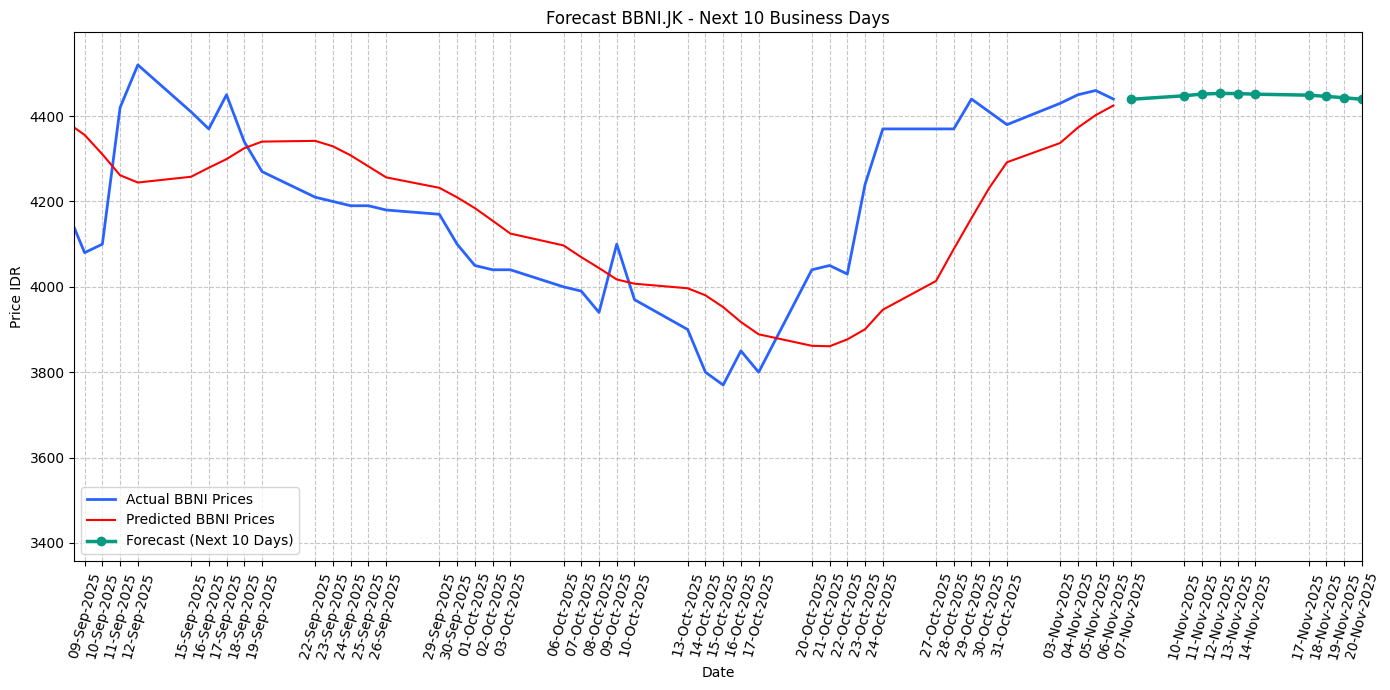

In [26]:
plt.figure(figsize=(14, 7))

y_test_plot = np.squeeze(y_test_scaled)
pred_plot = np.squeeze(predictions)

plt.plot(df.index[-len(y_test_plot):], y_test_plot, label='Actual BBNI Prices', color='#2962ff', linewidth=2.0)
plt.plot(df.index[-len(pred_plot):], pred_plot, label='Predicted BBNI Prices', color='red', linewidth=1.5)

# predictions for next 10 business days
plt.plot(future_predictions_df['Date'],
         future_predictions_df['Predicted Price BBNI'], label='Forecast (Next 10 Days)', color='#089981', linewidth=2.5, marker='o')

plt.title(f'Forecast {TICKER} - Next 10 Business Days')
plt.xlabel('Date')
plt.ylabel('Price IDR')

ax = plt.gca()

# start the day by today
start_plot = pd.Timestamp.now() - pd.Timedelta(days=60)
ax.set_xlim(left=start_plot, right=future_predictions_df['Date'].iloc[-1])

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=(mdates.MO, mdates.TU, mdates.WE, mdates.TH, mdates.FR)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))
plt.xticks(rotation=75)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
# show results future predictions

future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price BBNI': future_predictions
})

future_predictions_df.tail()

,Date,Predicted Price BBNI
5,2025-11-14,4451.385254
6,2025-11-17,4449.107910
7,2025-11-18,4446.264648
8,2025-11-19,4442.999512
9,2025-11-20,4439.435059


In [28]:
# calculate percentage change from the last actual close price
last_actual_price = float(df['Close'].iloc[-1])
predicted_last_price = float(future_predictions_df['Predicted Price BBNI'].iloc[-1])

# Ensure both values are scalars
percentage_change = ((predicted_last_price - last_actual_price) / last_actual_price) * 100

# Determine profit or loss
status = "profit" if percentage_change > 0 else "loss"
print(f"Percentage prediction for 10 days is: {status} {abs(percentage_change):.2f}%")

Percentage prediction for 10 days is: loss 0.01%
